In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
from netCDF4 import Dataset

from ipywidgets import FloatProgress
from IPython.display import display, clear_output, Latex
import cmocean
import pandas as pd
import xarray as xr
import scipy
from scipy.optimize import leastsq
import matplotlib.dates as mdates
import datetime
import dask.array as da
import scipy.ndimage as nd
import scipy.optimize as optim

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

In [2]:
## import functions
from MLD_fxns import *

In [3]:
start = datetime.datetime(2011,8,14)
end = datetime.datetime(2011,9,14)

beg = datetime.datetime(2006, 1, 1)
d1 = start-beg
d2 = end-beg
d1 = str(24*(d1.days + d1.seconds*60*60*24))
d2 = str(24*(d2.days + d2.seconds*60*60*24))
#print d1, d2
    # Make the URL
url = r'http://tds.marine.rutgers.edu/thredds/dodsC/cool/codar/totals/'
url2 = r'5Mhz_6km_realtime_fmrc/Maracoos_5MHz_6km_Totals-FMRC_best.ncd?'
gridurl = r'lon[0:1:154],lat[0:1:184]'
timeurl = r',time[{}:1:{}]'.format(d1, d2)
uurl = r',u[{}:1:{}][0:1:184][0:1:154]'.format(d1, d2)
vurl = r',v[{}:1:{}][0:1:184][0:1:154]'.format(d1, d2)

furl = url + url2 + gridurl + timeurl + uurl + vurl
    # The dataset from OpenDAP
data   = xr.open_dataset(furl)#, chunks={'time': 1000})
#aaaa   = Dataset(furl)

In [4]:
    # Get variables
lon = data.lon
lat = data.lat
u = data.u
v = data.v
t = data.time

t_vec = mdates.date2num(t)

In [5]:
year = 2011
thredds  = 'http://tds.marine.rutgers.edu/thredds/dodsC'
vwind_loc = thredds+'/met/ncdc-nam-3hour/Vwind_nam_3hourly_MAB_and_GoM_{}.nc'.format(str(year))
uwind_loc = thredds+'/met/ncdc-nam-3hour/Uwind_nam_3hourly_MAB_and_GoM_{}.nc'.format(str(year))

In [6]:
vwind_data = xr.open_dataset(vwind_loc)

In [7]:
uwind_data = xr.open_dataset(uwind_loc)

In [8]:
Vwind = vwind_data.Vwind
Uwind = uwind_data.Uwind
Twind = uwind_data.time
Ywind = uwind_data.lat
Xwind = uwind_data.lon

In [9]:
Twind = mdates.date2num(Twind)
deltaTwind = float(Twind[-1] - Twind[0])
dTwind = float(Twind[1] - Twind[0])

In [10]:
z=10
filtL = lanczos(41,63)
c = np.e/8

def slab_ocean_response(z, W, time, f, c):
    length = time.shape[0]
    Vi = 0.001 + 1j*(0.001)
    dt = time[1]-time[0]
    try:
        del data[:]
    except:
        data = np.ones(length,dtype='complex')
    data[0] = Vi
    for i in range(length-1):
        dVR = np.sum(rk4_Pollard_1d(data[i],dt,W[i],Zo=10,f=f,c=c));
        Vn  = data[i] + dVR # #rk4[i]
        data[i+1] = Vn
    #v_in = bandpass_fir_CODAR(V.imag, time, 18.2, 19.0)
    #u_in = bandpass_fir_CODAR(V.real, time, 18.2, 19.0)
    #Vamp_in = np.abs(data)
    return data

In [11]:
def fractional_rolls(Q,k,roll,t,y):
    dx = t[1]-t[0]
    qmin, qmax = np.nanmin(Q), np.nanmax(Q)
    guess = y[qmin-100:qmax+101]
    xg = t[qmin-100:qmax+101] - t[k]
    ypoly = np.polyfit(xg, guess, 20)
    p = np.poly1d(ypoly)
    g2 = p(xg+roll*dx)
    return g2[100:-100]

def error_function2D(x,k,t,observed,calculated):
    rmax = 36*(t[1]-t[0])
    r = np.abs((t-t[k])/rmax);
    Q = np.where(np.greater_equal(1,r));
    r = r[Q]
    twin = t[Q]
    w = (1-r**3)**3
    #rolled_calc = shift_signal_in_frequency_domain(calculated,10*x[1])
    rolled_calc = fractional_rolls(Q,k,36*x[1],t,calculated)
    #rolled_calc = np.roll(calculated,np.int(np.nan_to_num(100*x[1])))
    w_roll = 1+abs(x[1])**4
    return np.sum(np.abs(rolled_calc/x[0] - observed[Q])*w*100)*w_roll

In [12]:
buffer = 7*24 
dates = np.arange(buffer,len(t_vec)-buffer,1)
z0_data = np.zeros(len(dates))
phase_data = np.ones_like(z0_data)
t_data = np.ones_like(z0_data)

In [13]:
import multiprocessing

def parallel_2D_error(k, time, obs, calc):
    bnds = ((20, 300),(-1,1))
    vectorized_error = lambda x: error_function2D(x,k,time,observed=obs,calculated=calc) 
    x_init = np.random.uniform(low=bnds[0][0], high=bnds[0][1])
    y_init = np.random.uniform(low=bnds[1][0], high=bnds[1][1])
    res = optim.minimize(vectorized_error,[x_init, y_init], method='TNC', bounds=bnds)
    return time[k], res.x[0], res.x[1]

def parallel_error_fxn(k, time, obs, calc):
    bump=5
    bnds = ((1./50., 500),(-0.9,0.9))
    #k,time,obs,calc = K[0],K[1],K[2],K[3]
    vectorized_error = lambda x: error_function(x,k,time,obs,calc) 
    mldtemp = np.ones(bump)
    phasetemp = np.ones(bump)
    residtemp = np.ones(bump)
    for i in range(bump):
        x_init = np.random.uniform(low=bnds[0][0], high=bnds[0][1])
        y_init = np.random.uniform(low=bnds[1][0], high=bnds[1][1])
        res = optim.minimize(vectorized_error,[x_init, y_init], method='TNC', bounds=bnds)
        mldtemp[i]   = res.x[0]
        phasetemp[i] = res.x[1]
        residtemp[i] = res.fun
    mindex = np.where(residtemp == np.nanmin(residtemp))[0][0]
    return  time[k], mldtemp[mindex], phasetemp[mindex]

#def vect2D(k, time=t_vec, obs=obs, calc=calc):
#    return parallel_2D_error(k, time, obs, calc)

In [14]:
cores = multiprocessing.cpu_count()-1
print(cores)

7


## Make a map

In [84]:
bathurl = 'http://tds.marine.rutgers.edu/thredds/dodsC/other/bathymetry/w100w20s10n90.nc?lat[0:1:11999],lon[0:1:9599],elevation[0:1:11999][0:1:9599]'
bathdata = Dataset(bathurl, mode='r')
blat = bathdata.variables['lat']
blon = bathdata.variables['lon']
bath = bathdata.variables['elevation']

In [16]:
u_time_size = np.shape(u[:,0,0])[0]
date_get = dates

In [18]:
### Build domain variables
latsize = len(data.lat)
lonsize = len(data.lon)

i_lat = np.arange(0,latsize,1)
j_lon = np.arange(0,lonsize,1)

size = len(i_lat)*len(j_lon)*len(date_get)

z0_data    = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
phase_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
t_data     = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
c_data     = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
wi_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))
wr_data = np.ones(size, dtype=float).reshape(len(i_lat),len(j_lon),len(date_get))

In [19]:
nannums = np.zeros((len(i_lat), len(j_lon)))
cores = cores - 1

def getnans(position, variable):
    lat_index, lon_index = position[0], position[1]
    u_comp   = variable[:,lat_index,lon_index]
    nantotal = np.sum(np.isnan(u_comp))
    return 100*np.true_divide(nantotal,u_time_size)

def vectnans(position, variable=u):
    return getnans(k, variable)
     
positions = []

for m, lon_index in enumerate(j_lon):
    for n, lat_index in enumerate(i_lat):
        positions.append([n,m])
        
velshape = u.shape

In [20]:
u_np = np.ones(velshape)
for i in range(velshape[0]):
    u_np[i,:,:] = u[i,:,:]

In [21]:
v_np = np.ones(velshape)
for i in range(velshape[0]):
    v_np[i,:,:] = v[i,:,:]

In [22]:
nannums = np.apply_along_axis(lambda m: 100*np.sum(np.isnan(m))/float(m.shape[0]), axis=0, arr=u_np)
uclean = np.apply_along_axis(lambda m: np.nan_to_num(m), axis=0, arr=u_np)
vclean = np.apply_along_axis(lambda m: np.nan_to_num(m), axis=0, arr=v_np)

In [23]:
def slab_inertial(location,Vwind,Uwind,Twind,Xwind,Ywind,Tcodar):
    "return the slab inertial amplitude for a given location"
    # WRF Wind data for nearest point
    lon_get = location[0] 
    lat_get = location[1]
    distance_codar_sqr = np.array((Xwind-lon_get)**2 + (Ywind-lat_get)**2)
    kx, ky = np.where(distance_codar_sqr == np.nanmin(distance_codar_sqr))
    kx = int(kx); ky = int(ky)

    ## Format the data
    data_y = 3600*Vwind[:,ky,kx]
    data_x = 3600*Uwind[:,ky,kx]
    Wind_u = np.interp(t_vec, Twind, data_x)
    Wind_v = np.interp(t_vec, Twind, data_y)

    ## Coriolis for the lat
    f_sec = coriolis_frequency(lat_get)
    Fday = f_sec*60*60*24
    T_in = inertial_period(lat_get)/24.0
    low, high = 0.9*T_in, 1.1*T_in
    filt  = lanczos(int(np.ceil(48*T_in)),2*int(np.ceil(36*T_in))+1)

    ## Put wind into complex format
    WIND = Wind_u - 1j*Wind_v
    v_slab = slab_ocean_response(10,WIND,Tcodar,Fday,np.e/8)
    amp_slab = nd.maximum_filter(abs(v_slab),8)
    return np.abs(np.convolve(amp_slab,filtL,'same'))

def codar_inertial(uCodar,vCodar,latitude,Tcodar):
    T_in = inertial_period(latitude)/24.0
    low, high = 0.9*T_in, 1.1*T_in
    filt  = lanczos(int(np.ceil(48*T_in)),2*int(np.ceil(36*T_in))+1)

    vv_in = bandpass_fir_CODAR(vCodar, Tcodar, low, high)
    uu_in = bandpass_fir_CODAR(uCodar, Tcodar, low, high)
    VV_in = np.abs(uu_in + 1j*vv_in)
    VVamp_filt = nd.maximum_filter(abs(VV_in),8)
    return np.abs(np.convolve(VVamp_filt,filtL,'same'))

In [35]:
lonCODAR = data.lon
latCODAR = data.lat

positions_all = []
for m, Jlon in enumerate(j_lon):
    for n, Ilat in enumerate(i_lat):
        positions_all.append([n,m,Ilat,Jlon])

t_data = t_vec[date_get]

In [161]:
def naive_parallel(location, uclean=uclean, vclean=vclean, nannums=nannums, 
                   Vwind=Vwind, Uwind=Uwind, Twind=Twind, date_get=date_get,  
                   Xwind=Xwind,Ywind=Ywind,t_vec=t_vec, 
                   latCODAR=latCODAR, lonCODAR=lonCODAR):
    good = 0
    n,m,Ilat,Jlon = location
    returnmatrix = np.ones((4,len(date_get)))
    if nannums[Ilat,Jlon] > 10: 
        returnmatrix = returnmatrix*np.nan
    else:
        good = 1
        lon_get,lat_get = lonCODAR[Jlon],latCODAR[Ilat]
        u_comp = uclean[:,Ilat,Jlon]
        v_comp = vclean[:,Ilat,Jlon]
        calc = slab_inertial([lon_get,lat_get],Vwind,Uwind,Twind,Xwind,Ywind,t_vec)
        obs  = codar_inertial(u_comp,v_comp,lat_get,t_vec)
        
        def vect_in_loop(k, time=t_vec, obs=obs, calc=calc):
            return parallel_2D_error(k, time, obs, calc)

        returnmatrix[0,:] = obs[date_get]
        returnmatrix[1,:] = calc[date_get]
        for k, result in enumerate(map(vect_in_loop, date_get)):
            returnmatrix[2,k] = result[1]
            returnmatrix[3,k] = result[2]
    return int(n), int(m), int(Ilat), int(Jlon), returnmatrix, good

In [162]:
%%time
ddd = naive_parallel(positions_all[6000])

CPU times: user 1min 6s, sys: 41.2 ms, total: 1min 6s
Wall time: 1min 6s


In [38]:
cores = 8

In [39]:
p = multiprocessing.Pool(cores)

iterator = 0
now = datetime.datetime.now()
for k, result in enumerate(p.imap(naive_parallel, positions_all[:])):
    n, m, Ilat, Jlon, estimator_matrix, good = result
    c_data[n,m,:]     = estimator_matrix[0,:]
    wr_data[n,m,:]    = estimator_matrix[1,:]
    z0_data[n,m,:]    = estimator_matrix[2,:]
    phase_data[n,m,:] = estimator_matrix[3,:]
    lat_get, lon_get  = np.round(float(latCODAR[Ilat]),3), np.round(float(lonCODAR[Jlon]),3)
    clear_output()
    iterator += good
    if iterator > 0:
        timeprocess = datetime.datetime.now() - now
        speed = np.round(timeprocess.total_seconds()/float(iterator),3)
        display("Working on MLD at lat,lon = {},{}, at {} s/p, N = {}".format(lat_get, lon_get, 
                                                                              speed, str(int(iterator))))
p.close()

'Working on MLD at lat,lon = 43.474,-68.033, at 19.348 s/p, N = 4798'

In [40]:
p.close()

In [41]:
positions_all = []

for m, Jlon in enumerate(j_lon):
    for n, Ilat in enumerate(i_lat):
        positions_all.append([n,m,Ilat,Jlon])

In [40]:
%%time
for k, result in enumerate(map(vect_in_loop, dates)):
    z0_data[n,m,k]    = result[1]
    phase_data[n,m,k] = result[2]

CPU times: user 31 s, sys: 181 ms, total: 31.2 s
Wall time: 31.3 s


In [42]:
#  Find the depth from bathymetry
#findlat = np.abs(blat[:] - lat_get)
#findlon = np.abs(blon[:] - lon_get)
#bathlat =  np.where(findlat == np.min(findlat))[0][0]
#bathlon =  np.where(findlon == np.min(findlon))[0][0]
#D = abs(bath[bathlat,bathlon])
#clist = c_frombath(D,zlist,eps12h,eps96h)
#clist = c_bath_parabola(D,zlist,eps12h,eps96h,20.0)

In [43]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.gridspec as gridspec # GRIDSPEC !
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

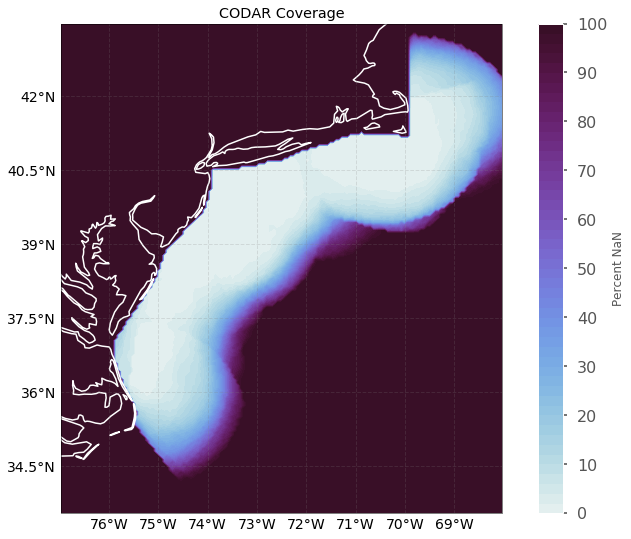

In [44]:
fig = plt.figure(1, figsize=(13,9))

ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title('CODAR Coverage')
kw = dict(levels=np.linspace(0,100,51), cmap=cmocean.cm.dense ,transform=ccrs.PlateCarree())
plt.contourf(lonCODAR, latCODAR, nannums, **kw)
ax.coastlines(resolution='50m', color='white', linewidth=1.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')

plt.colorbar(ticks=np.arange(0,101,10),label='Percent NaN')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}


plt.show()

In [90]:
X, Y = np.meshgrid(lonCODAR[j_lon], latCODAR[i_lat])

In [97]:
Dcodar = np.ones_like(X)*np.nan

for m, lon_index in enumerate(j_lon):
    for n, lat_index in enumerate(i_lat):
        if nannums[lat_index,lon_index] <= 10:
            latget = float(latCODAR[lat_index])
            longet = float(lonCODAR[lon_index])
            Dlat = np.abs(blat[:] - latget)
            Dlon = np.abs(blon[:] - longet)
            bathlat = np.where(Dlat == np.nanmin(Dlat))[0][0]
            bathlon = np.where(Dlon == np.nanmin(Dlon))[0][0]
            depthabs = np.abs(bath[bathlat,bathlon])
            Dcodar[n,m] = depthabs

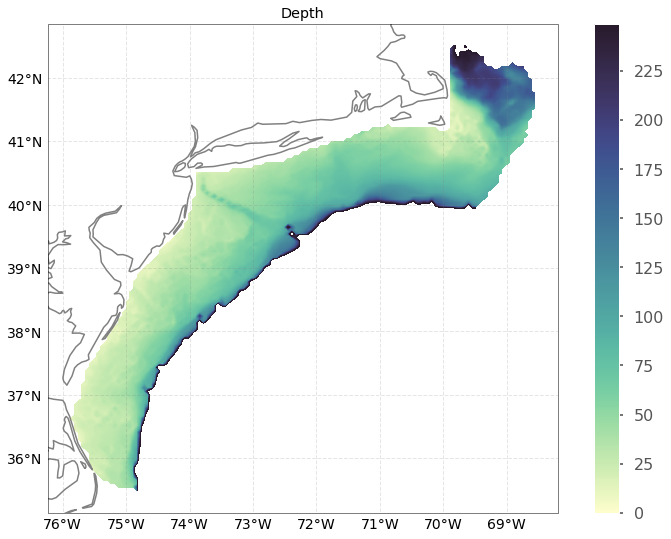

In [100]:
fig = plt.figure(1, figsize=(13,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title('Depth'.format(ikdate.year,ikdate.month,ikdate.day,ikdate.hour))
kw = dict(levels = np.arange(250), cmap=cmocean.cm.deep ,transform=ccrs.PlateCarree())
plt.contourf(X,Y,Dcodar, **kw)
ax.coastlines(resolution='50m', color='gray', linewidth=1.5)

plt.colorbar()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.show()

In [105]:
mld_filt = np.apply_along_axis(lambda m: scipy.signal.medfilt(m,7), axis=2, arr=z0_data)

### Making the Glider Figure

In [106]:
rutds = 'http://tds.marine.rutgers.edu/thredds/dodsC/'
gliderfile = rutds+'cool/glider/mab/Gridded/20110810T000000_20110906T000000_epa_ru16.nc'

In [107]:
gf = xr.open_dataset(gliderfile)

In [108]:
gtimenum = mdates.date2num(gf.time)
ireneT = mdates.date2num(datetime.datetime(2011,8,28,5,35)) # time at landfall for Irene at Brigantine
dIrene = np.abs(gtimenum - ireneT)
kIr    = np.where(dIrene == np.nanmin(dIrene))[0][0]
display(gf.time[kIr])

<xarray.DataArray 'time' ()>
array('2011-08-28T05:38:45.898331040', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2011-08-28T05:38:45.898331040
Attributes:
    long_name:  Time
    minimum:    2011-08-10 13:31:50
    maximum:    2011-09-06 19:05:29

In [111]:
Dg, Tg = np.meshgrid(gf.depth,gtimenum[kIr-300:kIr+200])
latg = float(gf.latitude[kIr])
long = float(gf.longitude[kIr])
Dlat = np.abs(latCODAR[:] - latg)
Dlon = np.abs(lonCODAR[:] - long)
latind = np.where(Dlat == np.nanmin(Dlat))[0][0]
lonind = np.where(Dlon == np.nanmin(Dlon))[0][0]
float(latCODAR[latind]),float(lonCODAR[lonind]), Dcodar[latind,lonind]

(39.212520599365234, -73.84071350097656, 39.0)

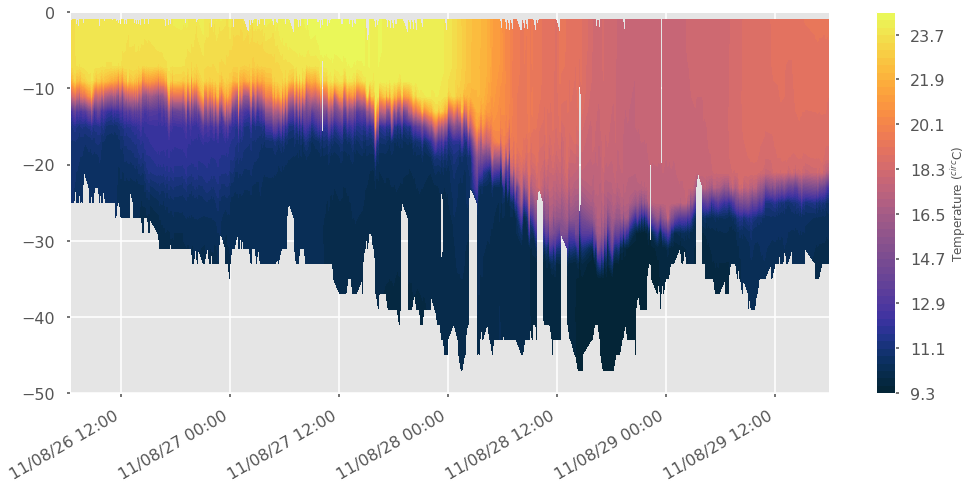

In [110]:
plt.figure(figsize=(17,7))

gtemps = plt.contourf(Tg,Dg,gf.temperature[kIr-300:kIr+200,:], levels = 50, cmap=cmocean.cm.thermal)
cb = plt.colorbar(gtemps, label='Temperature ($^{circ}$C)')


plt.ylim([-50,0])

myFmt = mdates.DateFormatter('%y/%m/%d %H:%M')
plt.xticks(rotation=30, horizontalalignment='right')
plt.gca().xaxis.set_major_formatter(myFmt)

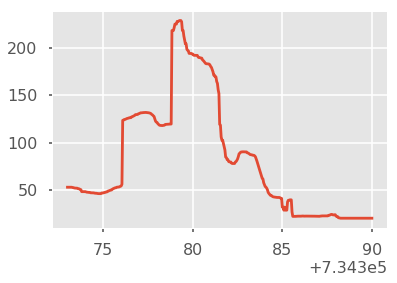

In [113]:
plt.plot(t_data,mld_filt[latind,lonind,:])

In [ ]:
gtimenum[]

In [117]:
a = np.arange(100).reshape(10,10)

In [119]:
a[::3,::2]

array([[ 0,  2,  4,  6,  8],
       [30, 32, 34, 36, 38],
       [60, 62, 64, 66, 68],
       [90, 92, 94, 96, 98]])

ValueError: 'bboxes' cannot be empty

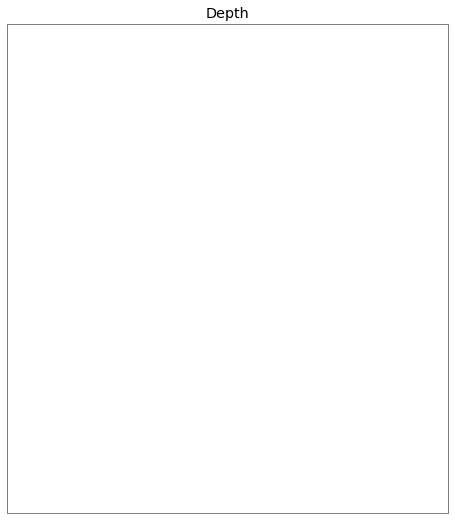

In [80]:
fig = plt.figure(1, figsize=(13,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title('Depth'.format(ikdate.year,ikdate.month,ikdate.day,ikdate.hour))
kw = dict(levels=np.linspace(0,200,51), cmap=cmocean.cm.deep ,transform=ccrs.PlateCarree())
plt.contourf(X,Y,Dcodar, **kw)
ax.coastlines(resolution='50m', color='gray', linewidth=1.5)

plt.colorbar()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.show()

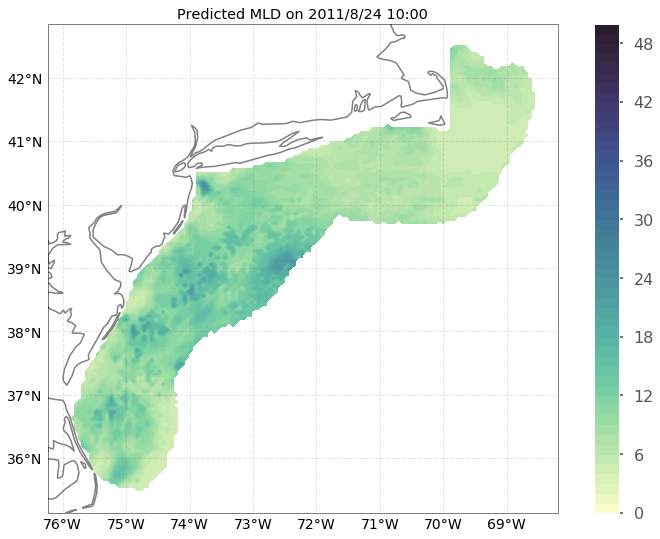

In [104]:
ik = 10
ikdate = mdates.num2date(t_data[ik])

mldplot = np.minimum(mld_filt[:,:,ik]/4,Dcodar)
mldplot = np.minimum(mldplot,np.ones_like(Dcodar)*50)

fig = plt.figure(1, figsize=(13,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title('Predicted MLD on {}/{}/{} {}:00'.format(ikdate.year,ikdate.month,ikdate.day,ikdate.hour))
kw = dict(levels=np.linspace(0,50,51), cmap=cmocean.cm.deep ,transform=ccrs.PlateCarree())
plt.contourf(X,Y,mldplot, **kw)
ax.coastlines(resolution='50m', color='gray', linewidth=1.5)

plt.colorbar()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.show()

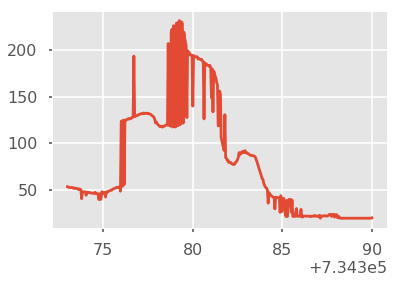

In [62]:
#plt.plot(c_data[24,20,:])
#plt.plot(wr_data[24,20,:]/25)

plt.plot(t_data,z0_data[105,54,:])

In [113]:
%%time
u_comp = u[:,lat_index,j_lon[n]]
nantotal = int(np.sum(np.isnan(u_comp)))

IndexError: index 36 is out of bounds for axis 0 with size 31

In [75]:
100*np.true_divide(nantotal,u_time_size)

24.529163337518547

<xarray.DataArray 'u' ()>
array(2149)
Coordinates:
    lon      float32 -74.6538
    lat      float32 35.7064
    time     datetime64[ns] 2012-01-04